This code is based on:

https://medium.com/@taposhdr/medical-image-analysis-with-deep-learning-i-23d518abf531

May want to look at rescaling the raw data to get standardized Hounsfield units:

https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import ipywidgets as widgets
import pydicom as pdicom
import os
import glob
import copy
import open3d as o3d
import scipy.ndimage
import time

from matplotlib import colors as mcolors
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.segmentation import clear_border
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import disk, dilation, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.filters import roberts, sobel
from skimage.filters import frangi, hessian
from scipy import ndimage as ndi
from open3d import JVisualizer

%matplotlib inline

### Helper printing functions

`plti` - plots the provided image.  
`sample_stack` - plots every x slice of a 3D image stack  
`pltm` - creates a simple two column grid of the provided images  
`pltHist` - prints a histogram from the provided image or stack. Defaults to labeling as Hounsfield units

In [4]:
def plti(im, h=8, title='',cmap='gray',**kwargs):
    y = im.shape[0]
    x = im.shape[1]
    w = (y/x) * h
    plt.figure(figsize=(w,h))
    plt.imshow(im, interpolation="none",cmap=cmap, **kwargs)
    plt.axis('off')
    plt.title(title)
    

In [5]:
def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3, size=12,cmap='gray'):
    fig,ax = plt.subplots(rows,cols,figsize=[size,size])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        if ind < stack.shape[2]:
            ax[int(i/cols),int(i % cols)].set_title('slice %d' % ind)
            ax[int(i/cols),int(i % cols)].imshow(stack[:,:,ind],cmap)
            ax[int(i/cols),int(i % cols)].axis('off')
    plt.show()

In [6]:
def pltm(images,h=8,titles=[],cmap='gray'):
    
    imNum = len(images)
    imX   = (imNum+1)//2
    
    y = images[1].shape[0]
    x = images[1].shape[1]
    w = (y/x) * h
    
    fig = plt.figure(figsize=(w,h))
    grid = ImageGrid(fig, 111,             # similar to subplot(111)
                     nrows_ncols=(imX, 2), # creates 2x2 grid of axes
                     axes_pad=0.25,           # pad between axes in inch.
                     )

    for i in range(imNum):
        grid[i].imshow(images[i],cmap=cmap)  # The AxesGrid object work as a list of axes.
        grid[i].axis('off')
        grid[i].set_xticks([])
        grid[i].set_yticks([])
        if len(titles) > i :
            grid[i].set_title(titles[i])  
            
    plt.show()

In [7]:
def pltHist(image, bins=50,xlabel="Hounsfield Units (HU)",ylabel="Frequency", color='c'):

    plt.hist(image.flatten(), bins=bins, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


### Datafile Reading

This section provides the functions to read in the provided. These routines do the following:  
* Get a list of all the dicom (.dcm) files in the input directory
* Read the dicom header off the first file and save the dimensions and space
* Generate a matrix of each pixel's distance from 0, 0, 0 based in the dimensions and space obtained from the header
* Read the dicom files (one slice to a file)

In [8]:
# INPUT_FOLDER = '/Users/john/Programming/Work/AnnotatedScans/Pat1068Padded'
#INPUT_FOLDER = '/Users/john/Programming/Work/Medtronic Samples/Pat002'
# INPUT_FOLDER = '/Users/john/Programming/Work/patient 1068'
INPUT_FOLDER = '/Users/john/Programming/Work/LungCT-Diagnosis-R_075/R_075/'



In [9]:
def load_scan2(path):
    
    lstFilesDCM = []

    for dirName, subdirList, fileList in os.walk(path):
        for filename in fileList:
            if ".dcm" in filename.lower():
                lstFilesDCM.append(os.path.join(dirName,filename))
#                 print(lstFilesDCM)

    lstFilesDCM.sort()
    return lstFilesDCM


In [10]:
def GetSpacing(RefDs):

    #Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    ConstPixelDims = np.asarray((int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM)+1))

    #Load spacing values (in mm)
    ConstPixelSpacing = np.asarray((float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness)))

    print('Pixel Dimensions: {}'.format(ConstPixelDims))
    print('Pixel Spacing:    {}'.format(ConstPixelSpacing))

    # print(RefDs.elements)
    
    return ConstPixelDims, ConstPixelSpacing


If you're interested in the measurement from 0,0,0 to any pixel, these arrays will show that. They're not currently used anywhere after this

In [11]:
def GenDimArray(ConstPixelDims, ConstPixelSpacing, doPrint=False):
    
    x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
    y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
    z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

    if doPrint:
        print(x,y,z)
        
    return x, y, z

In [12]:
def ReadDICOM(ConstPixelDims, lstFilesDCM, RefDs):

    # The array is sized based on 'ConstPixelDims'

    newDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

    # loop through all the DICOM files
    for filenameDCM in lstFilesDCM:
        # read the file
        ds = pdicom.read_file(filenameDCM)
        # Store the raw image data
        newDicom[:, :, pdicom.read_file(filenameDCM).InstanceNumber] = ds.pixel_array
    
    return newDicom


### Resampling

Use the metadata from the DICOM calculate the size of each voxel as the slice thickness and resampled into 1x1x1 mm pixels and slices.  

NOTE: When finished, the slices are normalized by subtracting off the min value of the entire stack (typically -1000)

In [13]:
def resample(image, spacing, new_spacing=[1,1,1]):

    resize_factor = new_spacing / spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

def shiftHouns(image):
    
    minH = np.min(image.flatten())
    image = image - minH
    return(image)


### Read the DICOM

This code sets up the segmentation code that follows by reading in the DICOM file and resizing it to 1 x 1 x 1mm.

Pixel Dimensions: [512 512 113]
Pixel Spacing:    [0.8671875 0.8671875 3.       ]
Slice Thickness: 3.000000
Original Pixel Spacing (row, col): (0.867188, 0.867188) 
Resample Pixel Spacing (row, col): (0.867188, 0.867188) 
Shape before resampling	 (512, 512, 113)
Shape after resampling	 (512, 512, 113)


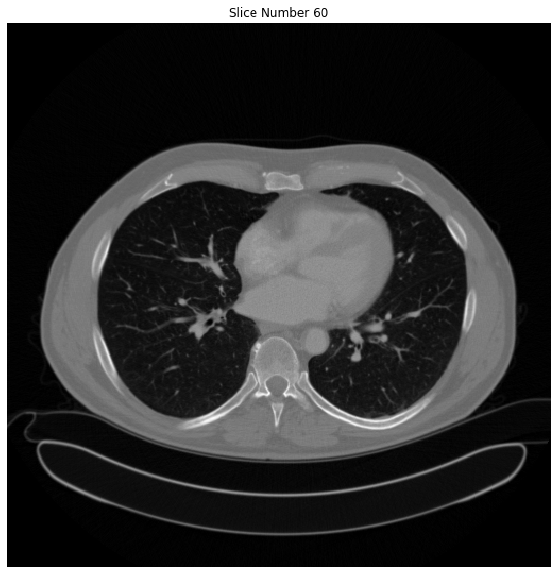

In [26]:
lstFilesDCM = load_scan2(INPUT_FOLDER)
lstFilesDCM.sort()
# print(lstFilesDCM)
    
RefDs = pdicom.read_file(lstFilesDCM[0])

ConstPixelDims, ConstPixelSpacing = GetSpacing(RefDs)
GenDimArray(ConstPixelDims, ConstPixelSpacing, False)

ArrayDicom = ReadDICOM(ConstPixelDims, lstFilesDCM, RefDs)

sliceNum = 60
plti(ArrayDicom[:, :, sliceNum],10,title = "Slice Number {}".format(sliceNum),cmap='gray')

img_resampled, spacing = resample(ArrayDicom, ConstPixelSpacing, new_spacing=ConstPixelSpacing)
# img_resampled, spacing = resample(ArrayDicom, ConstPixelSpacing, [1,1,1])

print("Slice Thickness: %f" % ConstPixelSpacing[2])
print("Original Pixel Spacing (row, col): (%f, %f) " % (ConstPixelSpacing[0], ConstPixelSpacing[1]))
print("Resample Pixel Spacing (row, col): (%f, %f) " % (spacing[0], spacing[1]))

print("Shape before resampling\t", ArrayDicom.shape)
print("Shape after resampling\t", img_resampled.shape)

img_resampled = shiftHouns(img_resampled)

### Segmentation

The following code originated from:

https://www.kaggle.com/terravic/lung-segmentation

It segments the lung from a provided DICOM slice. This code makes a few assumptions:
* The first is that we're interested in Hounsfield values under 604. It makes a binary mask using that threshold. 
* It then assumes that anything touching any edge of the slice is not of interest. That would be true for lung but other anatomy may extend off the scan  

The code follows this flow:
* Create a binary image based on a threshold
* Remove all objects that touch a scan edge
* label all remaining pixel islands
* Keep only the two islands which have the largest area
* Perform image closure
* Fill any remaining holes
* Use the result to mask the original image


In [27]:
# Scan specific values:

# Pat1068
# maskLowCutoff = 2000
# patNum = "1068"

# Pat002
maskLowCutoff = 500
patNum = "002"


Original Slice Hounsfield Units - Min: 0, Max: 2233


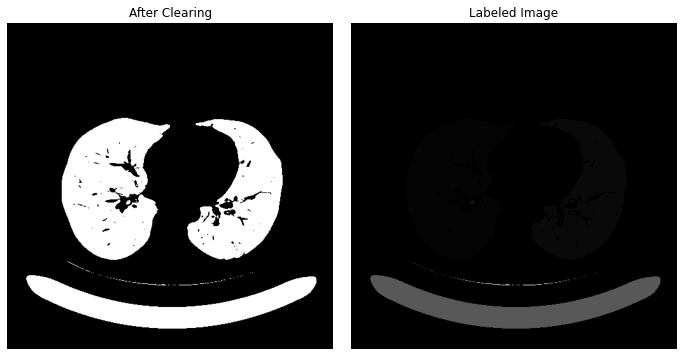

All labeled areas:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 6, 6, 6, 7, 9, 9, 17, 19, 20, 25, 35, 15383, 17406, 24403]


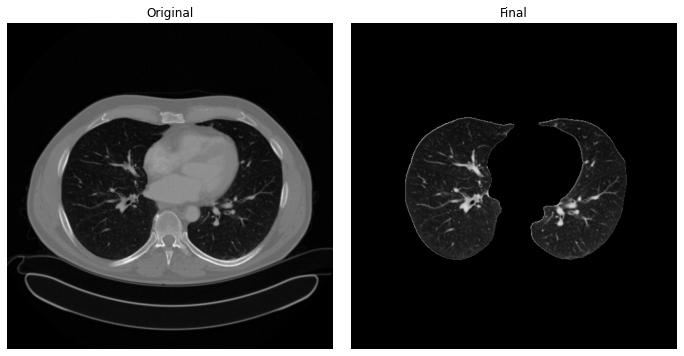

/Users/john/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: FutureWarning: Previously, hessian implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.


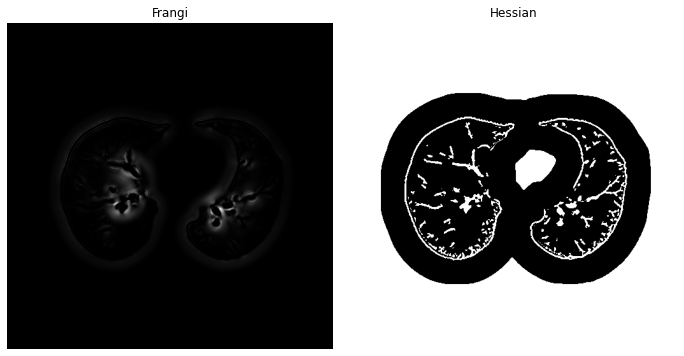

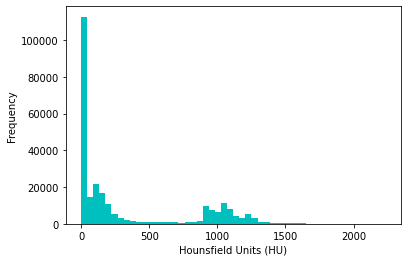

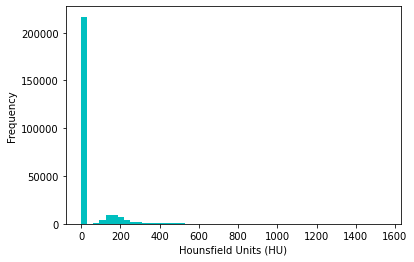

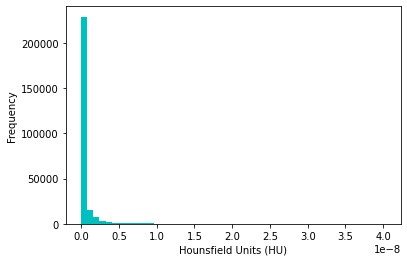

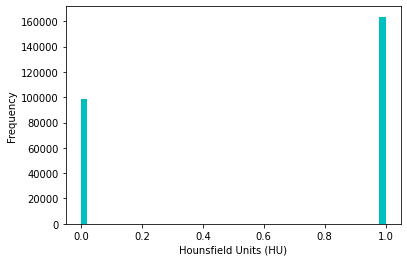

In [28]:
def get_segmented_lungs(slice):

    im = copy.deepcopy(slice)

    # Convert into a binary image. 
    binary = im < maskLowCutoff
    
    # Remove the blobs connected to the border of the image
    cleared = clear_border(binary)

    # Label the image
    label_image = label(cleared)

    pltm([cleared,label_image],12,['After Clearing','Labeled Image']) 
    
    # Keep the labels with 2 largest areas
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    print('All labeled areas: ',areas)
    for region in regionprops(label_image):
        if region.area < areas[-2]:
            for coordinates in region.coords:                
                label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0

    # Closure operation with disk of radius 12
    selem = disk(10)
    binary = binary_closing(binary, selem)
    
    # Fill in the small holes inside the lungs
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    
    # Superimpose the mask on the input image
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    
    return im

slice = copy.deepcopy(img_resampled[:, :, sliceNum])
print ('Original Slice Hounsfield Units - Min: {}, Max: {}'.format(np.min(slice), np.max(slice)))

segmented = get_segmented_lungs(slice)

pltm([slice,segmented],12,['Original','Final']) 

fr = frangi(segmented)
hes = hessian(segmented)
pltm([fr,hes],12,['Frangi','Hessian']) 

pltHist(slice)
pltHist(segmented)
pltHist(fr)
pltHist(hes)


### 2D Segmentation

This is my modifications to the original code. The primary changes are:'
* Print a histogram of the Hounsfield units over the slice
* Trim to a range of 1-500
* Labeling without removal of things touching the edges of the slice
* Keep only those labels whose area is amongst the top 4 and don't have a centroid at the top or bottom of the slice


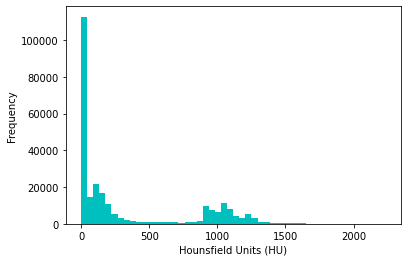

Hounsfield Units - Min:    0 Max: 2233
Total labeled areas:  52
Largest 10 areas: [9, 17, 19, 20, 25, 35, 15383, 17412, 24409, 106787]


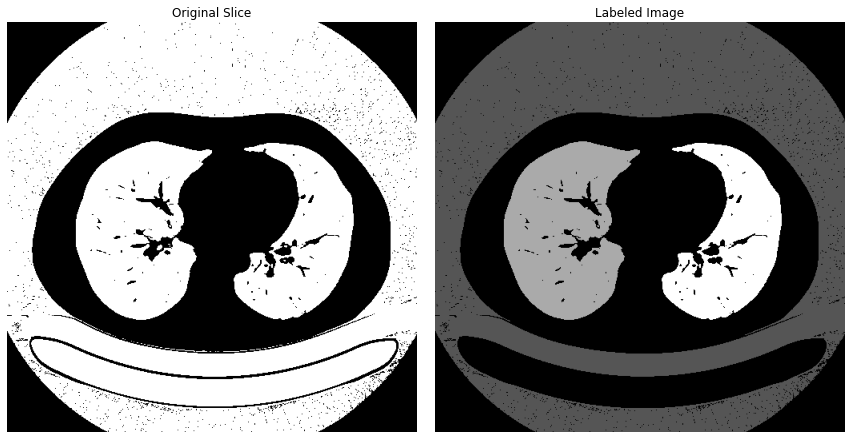

In [32]:
slice = copy.deepcopy(img_resampled[:, :, sliceNum])

pltHist(slice)

# This number seems to need to be fit to the CT being segmented. (e.g. Pat002 - 500, 1068Padded - 600)
highHounsCut = maskLowCutoff

# Convert to a binary mask after stripping off all the high Hounsfield values.
print('Hounsfield Units - Min: {:4d} Max: {:4d}'.format(np.min(slice),np.max(slice)))
slice[np.where(slice > highHounsCut)] = 0
slice[np.where(slice > 0)] = 1

label_image = label(slice)

areas = [r.area for r in regionprops(label_image)]
centers = [r.centroid for r in regionprops(label_image)]
areas.sort()

topAreas = 10
print('Total labeled areas: ',len(regionprops(label_image)))
print('Largest {} areas: {}'.format(topAreas,areas[-topAreas:]))

for region in regionprops(label_image):
    if (region.area < areas[-4]) or (region.centroid[0] > 400) or (region.centroid[0] < 100):
        for coordinates in region.coords:                
            label_image[coordinates[0], coordinates[1]] = 0
        
# label_image = label(slice, neighbors=4, connectivity=2)
pltm([slice,label_image],15,['Original Slice','Labeled Image']) 



### 3D Segmentation

This is the same algorithm as that used for the 2D segmentation but for entire dicom stack. The primary changes are:
* `minAreaPct` defines how small a labeled 3D area must be considered as a useful area as a percentage of the total 3D volume
* `maxSizePct` defines how much big a labeled 3D object can be as measured by x and y dimensions as a percentage of the x and y slice dimensions
* Upon completion, the image labels are updated to remove rejected labels.

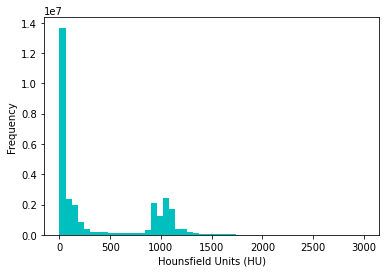

Hounsfield Units - Min:    0 Max: 3000
Labeling...
Getting initial areas
Total areas:  379
Largest 10 areas: [967, 998, 1109, 1311, 2132, 2162, 2562, 1671226, 2528523, 12363251]
Removing small areas
Re-indexing remaining areas
Total remaining regions: 2
Largest 10 areas: [2528523, 1671226]


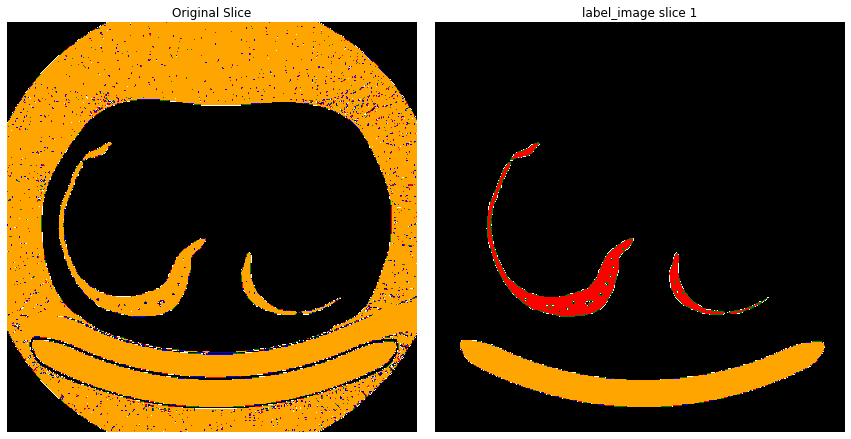

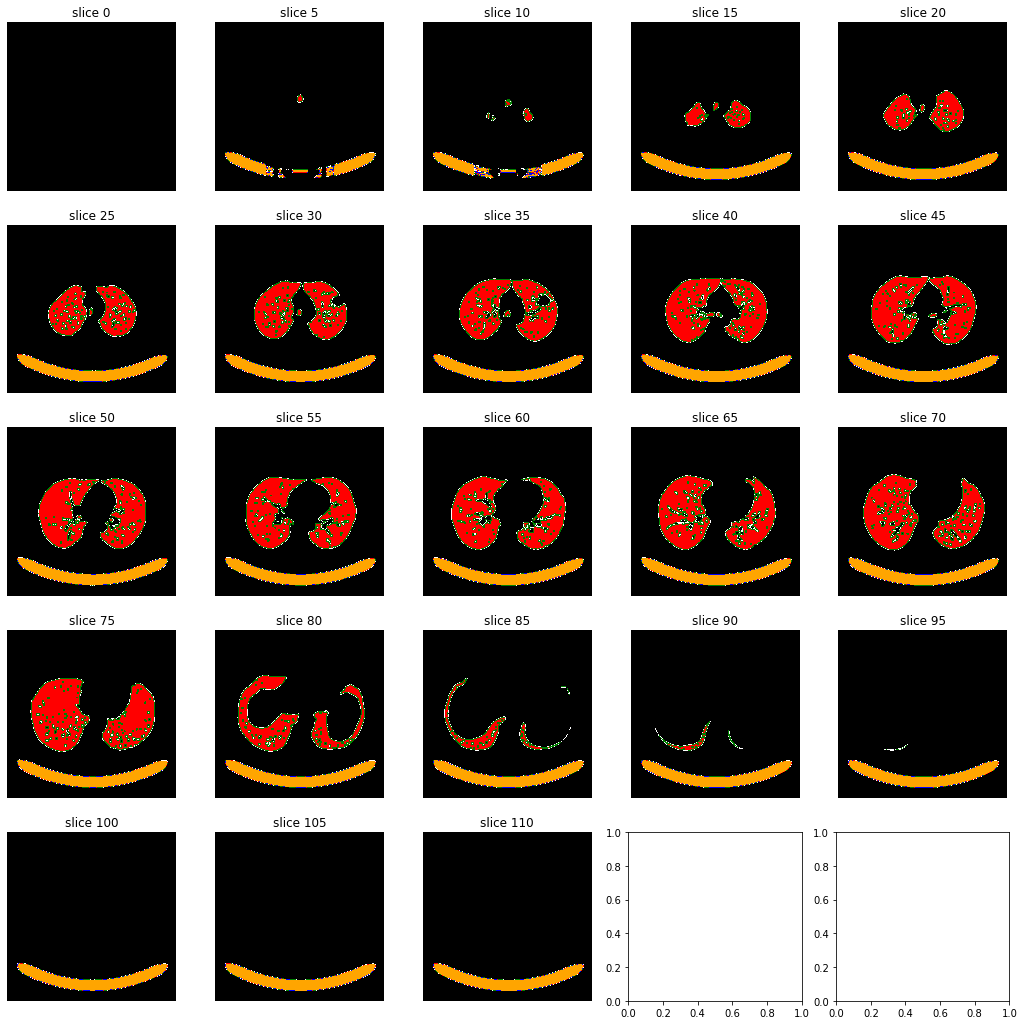

In [33]:
slice = copy.deepcopy(img_resampled[:, :, :])
slice[np.where(slice > 3000)] = 0

pltHist(slice)

# Convert to a binary mask after stripping off all the high Hounsfield values.
print('Hounsfield Units - Min: {:4d} Max: {:4d}'.format(np.min(slice),np.max(slice)))
slice[np.where(slice > highHounsCut)] = 0
slice[np.where(slice > 0)] = 1

print('Labeling...')
label_image = label(slice)

# Limits on area and size to get rid of things too big or too small
minAreaPct = 0.05
totalArea = slice.shape[0] * slice.shape[1] * slice.shape[2]
areaLimit = totalArea * minAreaPct
maxSizePct = 0.98
xMax = label_image.shape[0]*maxSizePct
yMax = label_image.shape[1]*maxSizePct

print('Getting initial areas')
areas = [r.area for r in regionprops(label_image)]
areas.sort()

topAreas = 10
print('Total areas: ',len(regionprops(label_image)))
print('Largest {} areas: {}'.format(topAreas,areas[-topAreas:]))

print('Removing small areas')
remainingRegions = []
for region in regionprops(label_image):
    xLen = region.bbox[3]-region.bbox[0]
    yLen = region.bbox[4]-region.bbox[1]
    if region.area < areaLimit or xLen > xMax or yLen > yMax :
        for coordinates in region.coords:
            label_image[coordinates[0], coordinates[1], coordinates[2]] = 0
    else:
        remainingRegions.append(region)

# This is some code to print one slice from each labeled area. It doesn't check to see if the object is actually
# in the slice being printed however.

# for region in remainingRegions:
#     tmp_image = copy.deepcopy(label_image)
#     tmp_label = region.label
#     for otherR in remainingRegions:
#         if otherR.label != tmp_label:
#             for coordinates in otherR.coords:
#                 tmp_image[coordinates[0], coordinates[1], coordinates[2]] = 0
#     plti(tmp_image[:,:,87],title = "tmp_label {}, bbox {}, area {}".format(tmp_label,region.bbox,region.area),cmap=cmap)
            

print('Re-indexing remaining areas')
finalRegions = []
areaX = []
idx = 1
for region in remainingRegions:
    region.label = idx
    finalRegions.append(region)
    areaX.append(region.area)
    for coordinates in region.coords:                
        label_image[coordinates[0], coordinates[1], coordinates[2]] = idx
    idx += 1

areas = [r.area for r in finalRegions]
print('Total remaining regions: {}'.format(len(finalRegions)))
print('Largest {} areas: {}'.format(topAreas,areas[-topAreas:]))

cmap = colors.ListedColormap(['black','white', 'green', 'red', 'blue', 'orange'])

pltm([slice[:,:,87],label_image[:,:,87]],15,['Original Slice','label_image slice 1'],cmap=cmap)

stepSize = 5
show_image = label_image[:,:,:]
sample_stack(show_image, rows=int(np.ceil(show_image.shape[2]/5/stepSize)), cols=5, size=18, start_with=0, show_every=stepSize,cmap=cmap)

# sample_stack(label_image, rows=6, cols=8, size=15)



In [34]:
from scipy import ndimage

a = np.array([1,2,3,8,9,10])
print(ndimage.standard_deviation(a))

b = np.array([4,5,6,7,8])
print(ndimage.standard_deviation(b))

topAreas = 10
print('Total areas: ',len(regionprops(label_image)))
print('Largest {} areas: {}'.format(topAreas,areas[-topAreas:]))

print(type(regionprops(label_image)))

3.593976442141304
1.4142135623730951
Total areas:  2
Largest 10 areas: [2528523, 1671226]
<class 'list'>


In [35]:
def writePointCloud(image,outfile,dSamplefile,color = 'olivedrab',xyz=False,voxel_size=10):
    print('Stacking coordinates')
    lung_idx = np.nonzero(image)
    lung_stack = np.hstack((lung_idx[0].reshape(-1,1),lung_idx[1].reshape(-1,1),lung_idx[2].reshape(-1,1)))
    
    print('Adding Color')
    colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

    itemColor = mcolors.to_rgb(colors[color])

    colorR = np.zeros(list(lung_stack.shape))
    for c in range(0,3):
        colorR[:,c].fill(itemColor[c])

    print('Converting to Point Cloud')
    point_cloud = o3d.PointCloud()
    point_cloud.points = o3d.Vector3dVector(lung_stack)
    point_cloud.colors = o3d.Vector3dVector(colorR)

    print('Writing Point Cloud')
    o3d.io.write_point_cloud(outfile + '.pcd', point_cloud, write_ascii=True)

    print("Downsample the point cloud with a voxel of {}".format(voxel_size))
    point_cloud = o3d.io.read_point_cloud(outfile + '.pcd')
    downpcd = o3d.geometry.voxel_down_sample(point_cloud,voxel_size=voxel_size)

    print('Original size:    {}'.format(np.asarray(point_cloud.points).shape))
    print('Downsampled size: {}'.format(np.asarray(downpcd.points).shape))

    print('Writing Point Cloud')
    o3d.io.write_point_cloud(dSamplefile + '.pcd', point_cloud, write_ascii=True)

    # print('Showing Point Cloud')
    # fragment = o3d.io.read_point_cloud('test2.pcd')
    # visualizer = JVisualizer()
    # visualizer.add_geometry(fragment)
    # visualizer.show()
    
    if xyz == True:
        np.savetxt(outfile + '.xyz', point_cloud.points, delimiter=' ', fmt='%d')
        np.savetxt(dSamplefile + '.xyz', downpcd.points, delimiter=' ', fmt='%d')
        np.savetxt(dSamplefile + '.pts',downpcd.points,fmt='p %d %d %d')
    
    print('Done')


In [36]:
writePointCloud(show_image,'test'+patNum,'test'+patNum+'d')

Stacking coordinates
Adding Color
Converting to Point Cloud


AttributeError: module 'open3d' has no attribute 'PointCloud'

In [37]:
import math

def sigmoid(size,sigma):

    # Create square windows of size n by n from a Gaussian (h) and Gaussian derivative (hx, hy) of width sigma
    nn = int((size-1)/2)
    h = np.zeros((size,size))
    hx = np.zeros((size,size))
    hy = np.zeros((size,size))
    
    a = np.asarray([[x**2 + y**2 for x in range(-nn,nn+1)] for y in range(-nn,nn+1)])
    mx = np.asarray([[x for x in range(-nn,nn+1)] for y in range(-nn,nn+1)])
    my = np.asarray([[y for x in range(-nn,nn+1)] for y in range(-nn,nn+1)])
    
    h  = (( 1/(2*np.pi*sigma**2))* np.exp(-a/(2*sigma**2)));
    hy = ((my/(2*np.pi*sigma**4))* np.exp(-a/(2*sigma**2)))*159;
    hx = ((mx/(2*np.pi*sigma**4))* np.exp(-a/(2*sigma**2)))*159;

    h  = h/h.max()
    hx = hx/hx.max()
    hy = hy/hy.max()

    return h, hx, hy

def sigmoid3d(size,sigma):

    # Create square windows of size n by n from a Gaussian (h) and Gaussian derivative (hx, hy) of width sigma
    nn = int((size-1)/2)
    h = np.zeros((size,size))
    hx = np.zeros((size,size))
    hy = np.zeros((size,size))
    
    a = np.asarray([[[x**2 + y**2 + z**2 for x in range(-nn,nn+1)] for y in range(-nn,nn+1)] for z in range(-nn,nn+1)])
    mx = np.asarray([[[x for x in range(-nn,nn+1)] for y in range(-nn,nn+1)] for z in range(-nn,nn+1)])
    my = np.asarray([[[y for x in range(-nn,nn+1)] for y in range(-nn,nn+1)] for z in range(-nn,nn+1)])
    mz = np.asarray([[[z for x in range(-nn,nn+1)] for y in range(-nn,nn+1)] for z in range(-nn,nn+1)])
    
    h  = (( 1/(2*np.pi*sigma**2))* np.exp(-a/(2*sigma**2)));
    hy = ((my/(2*np.pi*sigma**4))* np.exp(-a/(2*sigma**2)))*159;
    hx = ((mx/(2*np.pi*sigma**4))* np.exp(-a/(2*sigma**2)))*159;
    hz = ((mz/(2*np.pi*sigma**4))* np.exp(-a/(2*sigma**2)))*159;

    h  = h/h.max()
    hx = hx/hx.max()
    hy = hy/hy.max()
    hz = hz/hz.max()

    return h, hx, hy, hz



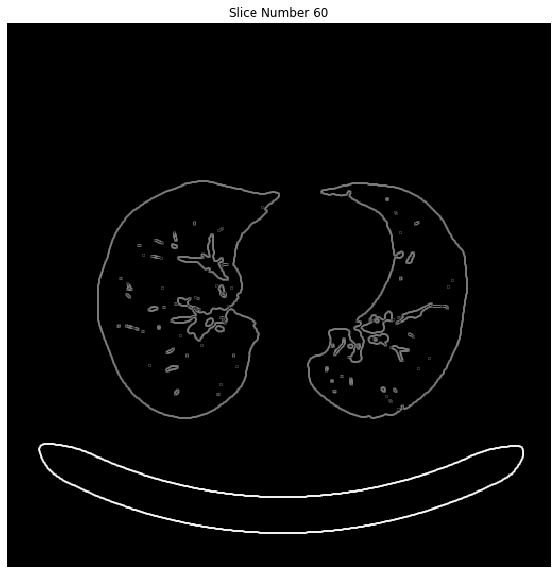

In [38]:
from scipy.signal import convolve2d

_, ax, ay = sigmoid(3,1.5)

slice = show_image[:, :, sliceNum]

sx = convolve2d(slice, ax, mode="same", boundary="symm")
sy = convolve2d(slice, ay, mode="same", boundary="symm")
im_grad = (np.sqrt(sx*sx + sy*sy))

plti(im_grad,10,title = "Slice Number {}".format(sliceNum),cmap='gray')



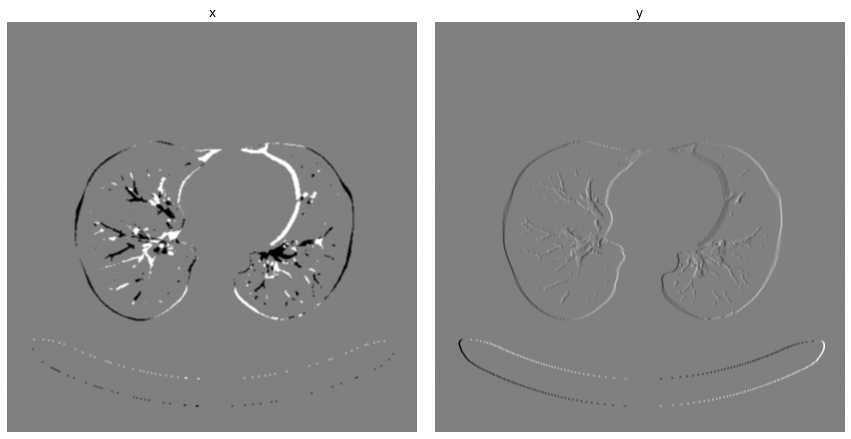

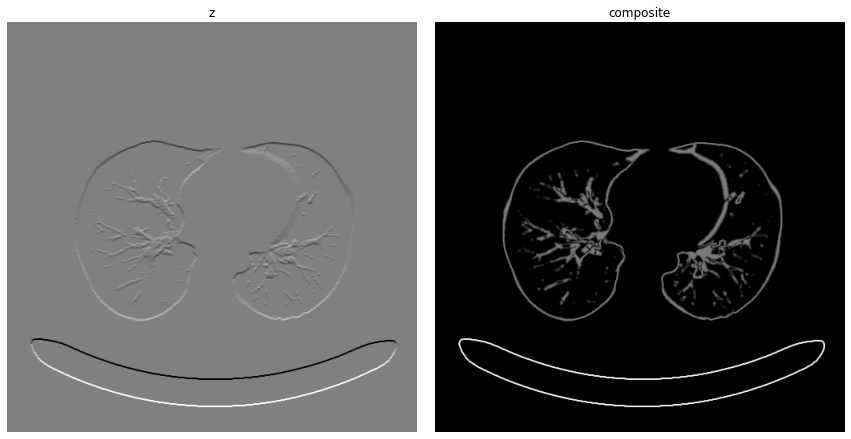

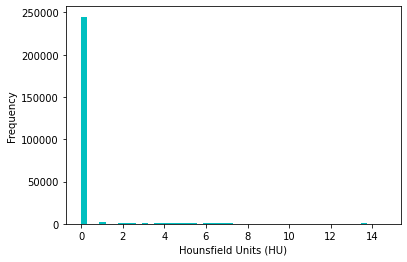

0

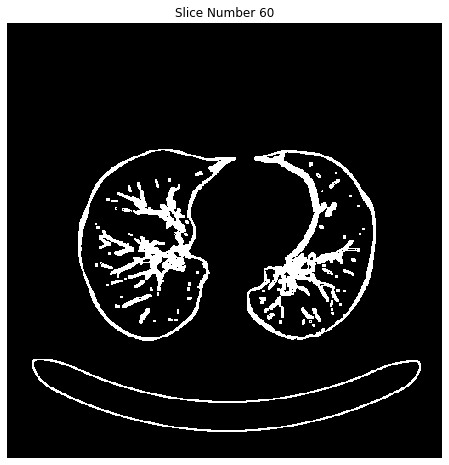

In [39]:
from scipy import signal

_, ax, ay, az = sigmoid3d(3,1.5)

sx2 = signal.fftconvolve(show_image, ax, mode='same')
sy2 = signal.fftconvolve(show_image, ay, mode='same')
sz2 = signal.fftconvolve(show_image, az, mode='same')
im_conv = (np.sqrt(sx2*sx2 + sy2*sy2 + sz2*sz2))
im_angl = (np.arctan2((sy2*sy2),(sx2*sx2)))

pltm([sx2[:, :, sliceNum],sy2[:, :, sliceNum]],15,['x','y'],cmap='gray')
pltm([sz2[:, :, sliceNum],im_conv[:, :, sliceNum]],15,['z','composite'],cmap='gray')

# im_gaus = scipy.ndimage.gaussian_filter1d(slice, sigma = 1.0)
# plti(im_conv,10,title = "Slice Number {}".format(sliceNum),cmap='gray')

# Convert to a mask.
im_convm = np.zeros_like(im_conv)
im_convm[np.where(im_conv > 0.8)] = 1

pltHist(im_conv[:, :, sliceNum])

plti(im_convm[:, :, sliceNum],8,title = "Slice Number {}".format(sliceNum),cmap='gray')

os.system("printf '\a'") # or '\7'

In [67]:
writePointCloud(im_convm,'test'+patNum+'x','test'+patNum+'xd',xyz=True,voxel_size=5)

os.system("printf '\a'") # or '\7'
# writeXYZ(im_convm,'test3.xyz')

Stacking coordinates
Adding Color
Converting to Point Cloud
Writing Point Cloud
Downsample the point cloud with a voxel of 5
Original size:    (4642858, 3)
Downsampled size: (70666, 3)
Writing Point Cloud
Done


0

### 2D Version

This is a demo for extracting the details in the mask area on a single slice.

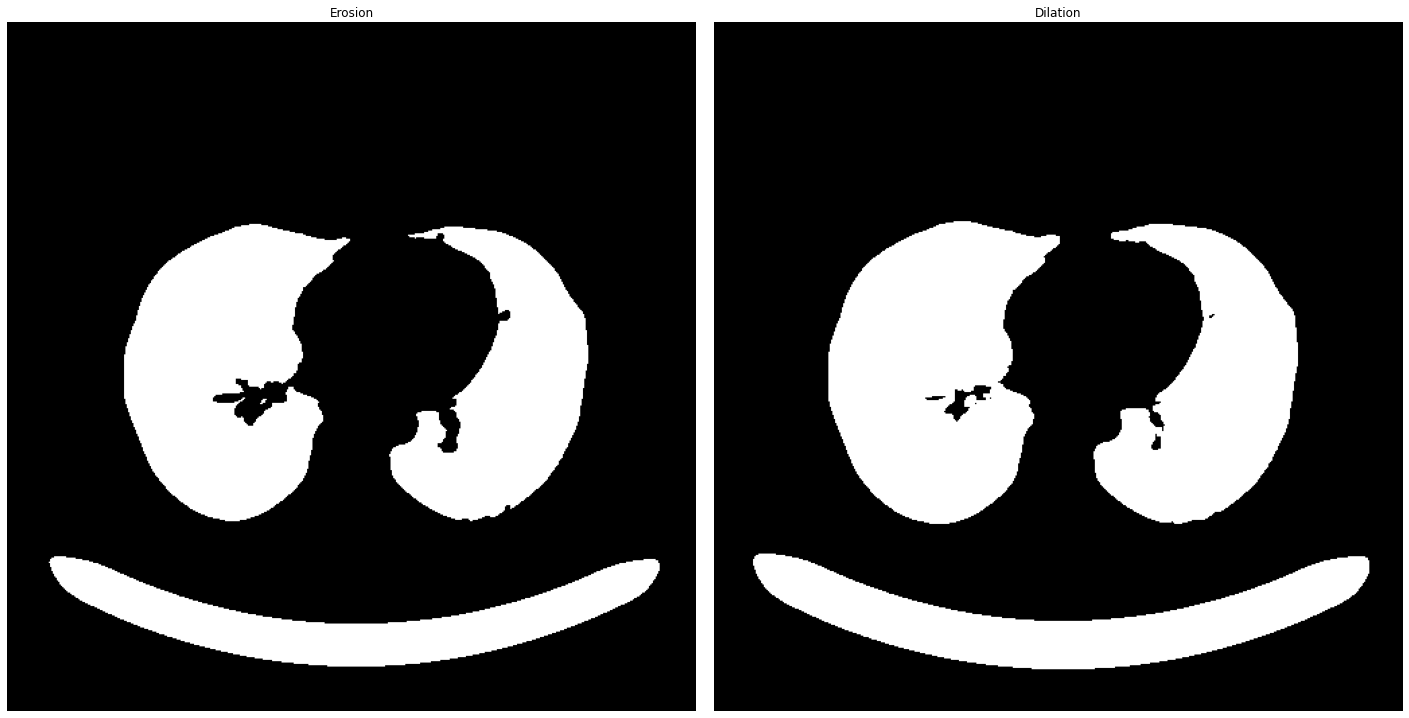

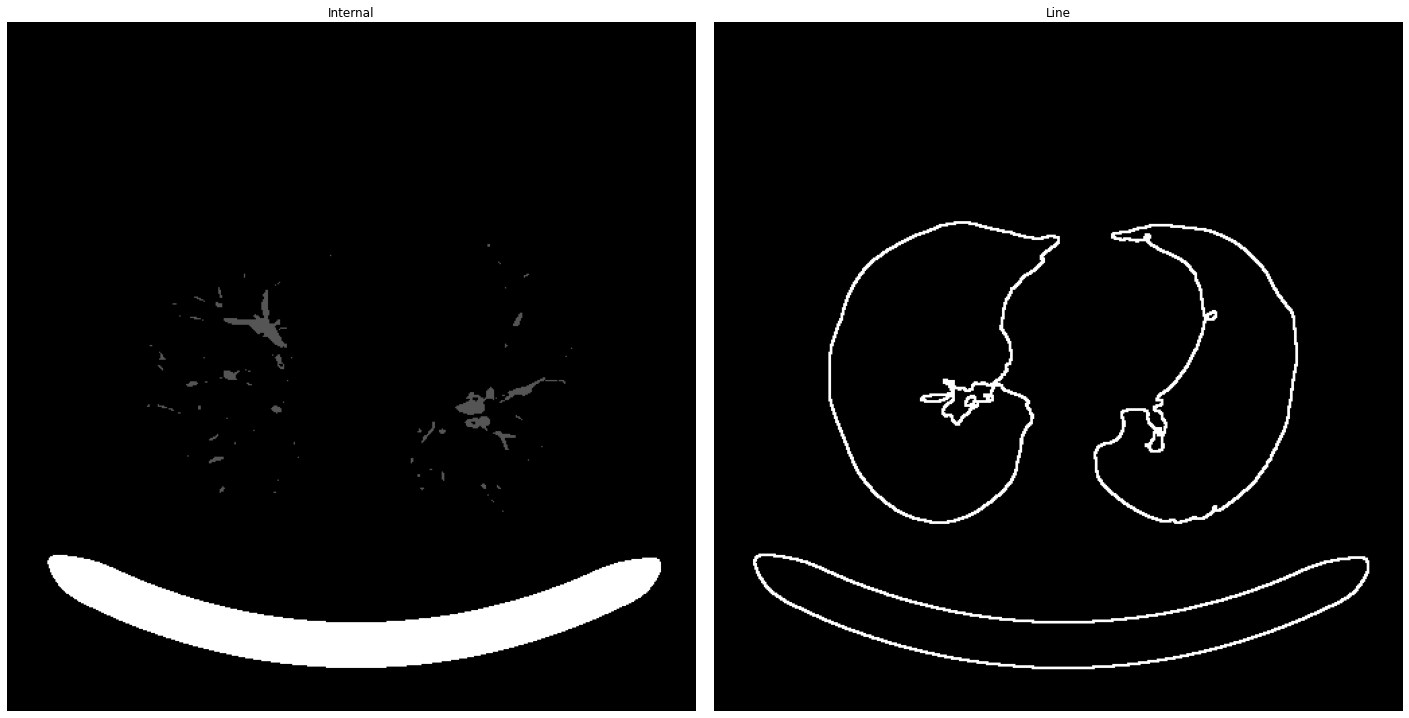

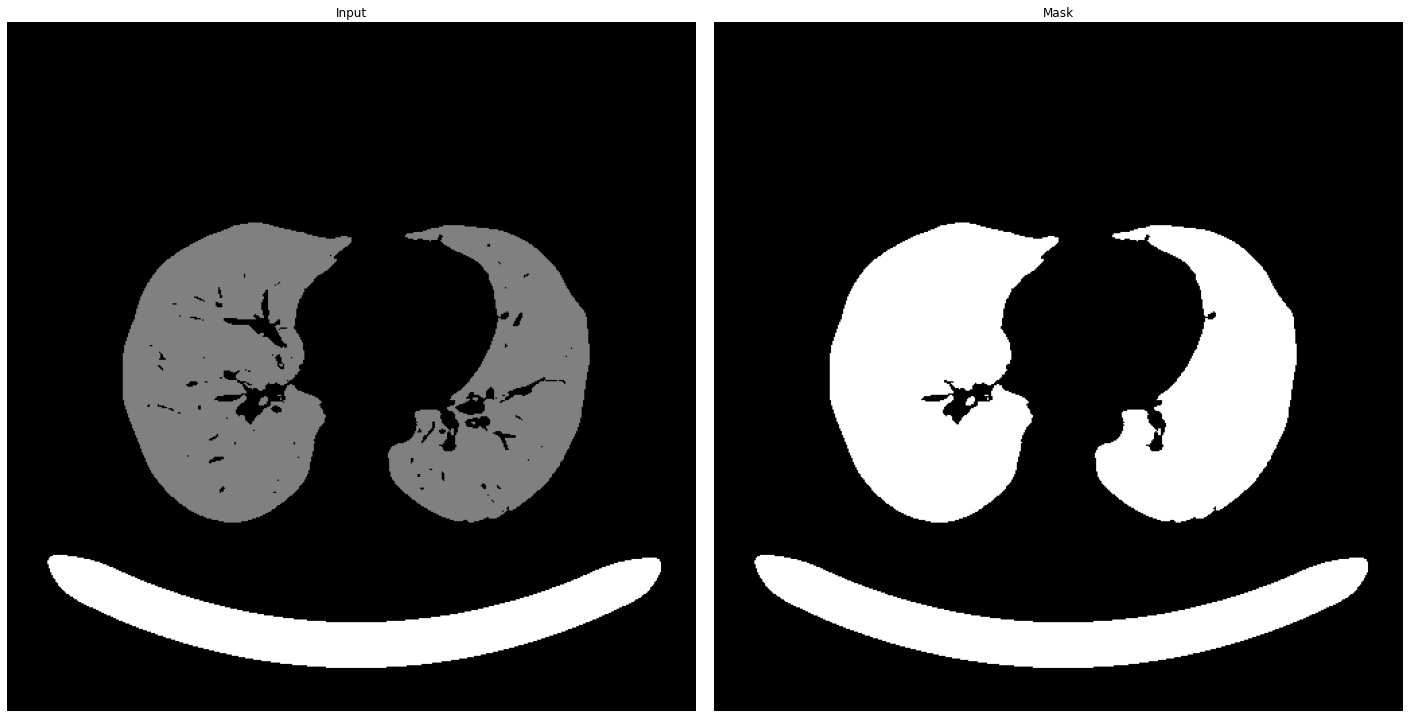

0

In [42]:
kernel = np.ones((3,3), np.uint8)

img = label_image[:,:,sliceNum].astype(np.uint8)

mask = img.copy()
cv2.floodFill(mask, None, (0, 0), 255)

mask = cv2.bitwise_not(mask)
mask[np.where(mask > 0)] = 1

img_erosion = cv2.erode(mask, kernel, iterations=1)
img_dilation = cv2.dilate(mask, kernel, iterations=1)
img_line = cv2.bitwise_xor(img_erosion,img_dilation)
img_internal = cv2.bitwise_xor(img,mask)
# img_internal = img - mask

pltm([img_erosion,img_dilation],25,['Erosion','Dilation'],cmap='gray')
pltm([img_internal,img_line],25,['Internal','Line'],cmap='gray')
pltm([img,mask],25,['Input','Mask'],cmap='gray')

os.system("printf '\a'") # or '\7'

### 3D Version

This function uses labeling to identify small objects and remove them. The labeled objects smaller than a specified area are removed from the image.

In [46]:
def dustImage(image, minArea=1) :
    
    slice = copy.deepcopy(image[:, :, :]).astype(np.uint8)
    slice[np.where(slice > 3000)] = 0

    pltHist(slice)

    # Convert to a binary mask after stripping off all the high Hounsfield values.
    print('Hounsfield Units - Min: {:4d} Max: {:4d}'.format(np.min(slice),np.max(slice)))
    slice[np.where(slice > highHounsCut)] = 0
    slice[np.where(slice > 0)] = 1

    print('Labeling...')
    label_image = label(slice, connectivity=1)

    topAreas = 15

    print('Getting initial areas')
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()

    print('Total areas: ',len(regionprops(label_image)))
    print('Smallest {} areas: {}'.format(topAreas,areas[0:topAreas]))

    print('Removing small areas')
    remainingRegions = []
    for region in regionprops(label_image):
        if region.area < minArea :
            for coordinates in region.coords:
                label_image[coordinates[0], coordinates[1], coordinates[2]] = 0
        else:
            remainingRegions.append(region)

#     print('Re-indexing remaining areas')
#     finalRegions = []
#     areaX = []
#     idx = 1
#     for region in remainingRegions:
#         region.label = idx
#         finalRegions.append(region)
#         areaX.append(region.area)
#         for coordinates in region.coords:                
#             label_image[coordinates[0], coordinates[1], coordinates[2]] = idx
#         idx += 1

    areas = [r.area for r in remainingRegions]
    areas.sort()
    print('Total remaining regions: {}'.format(len(remainingRegions)))
    print('Smallest {} areas: {}'.format(topAreas,areas[0:topAreas]))
    print('Largest {} areas: {}'.format(topAreas,areas[-topAreas:]))

    cmap = colors.ListedColormap(['black','white', 'green', 'red', 'blue', 'orange', 'purple'])

    label_image[np.where(label_image > 0)] = 1
    label_image = label_image.astype(np.uint8)
    
    pltm([slice[:,:,100],label_image[:,:,100]],15,['Original Slice','label_image slice 1'],cmap=cmap)

#     stepSize = 5
#     show_image = label_image[:,:,:]
#     sample_stack(show_image, rows=int(np.ceil(show_image.shape[2]/5/stepSize)), cols=5, size=18, start_with=0, show_every=stepSize,cmap=cmap)

    return label_image


copying
generating
cleaning


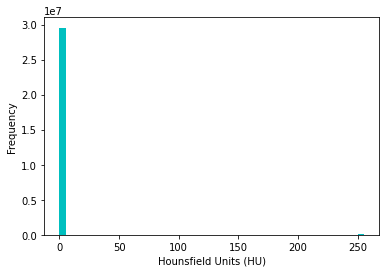

Hounsfield Units - Min:    0 Max:  255
Labeling...
Getting initial areas
Total areas:  3565
Smallest 15 areas: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Removing small areas
Total remaining regions: 64
Smallest 15 areas: [101, 102, 106, 111, 113, 116, 119, 121, 123, 124, 129, 129, 136, 138, 146]
Largest 15 areas: [766, 772, 780, 800, 1050, 1072, 1781, 1997, 2117, 2601, 3521, 5906, 9320, 9325, 9982]


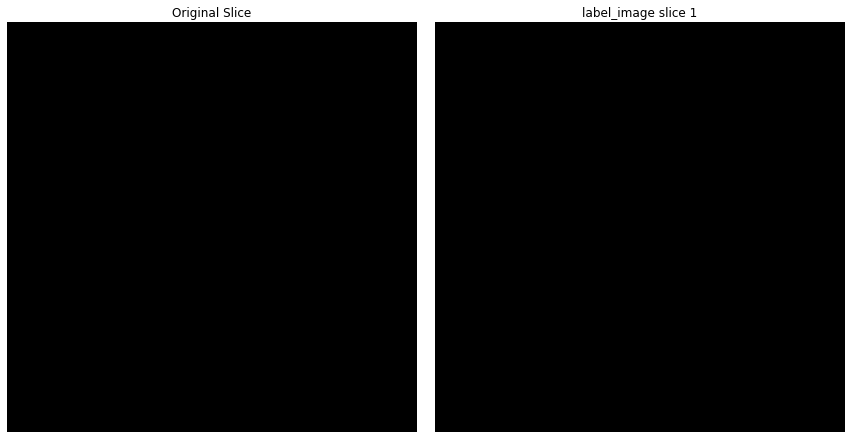

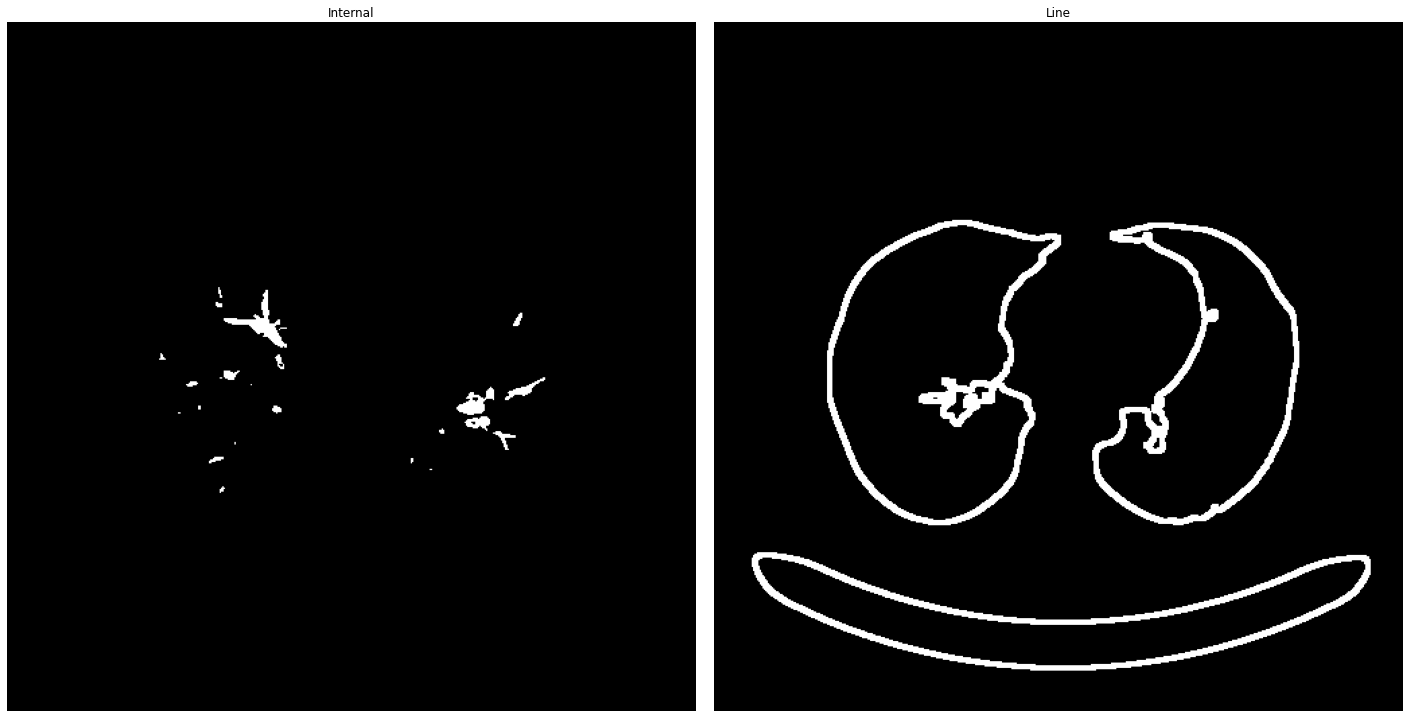

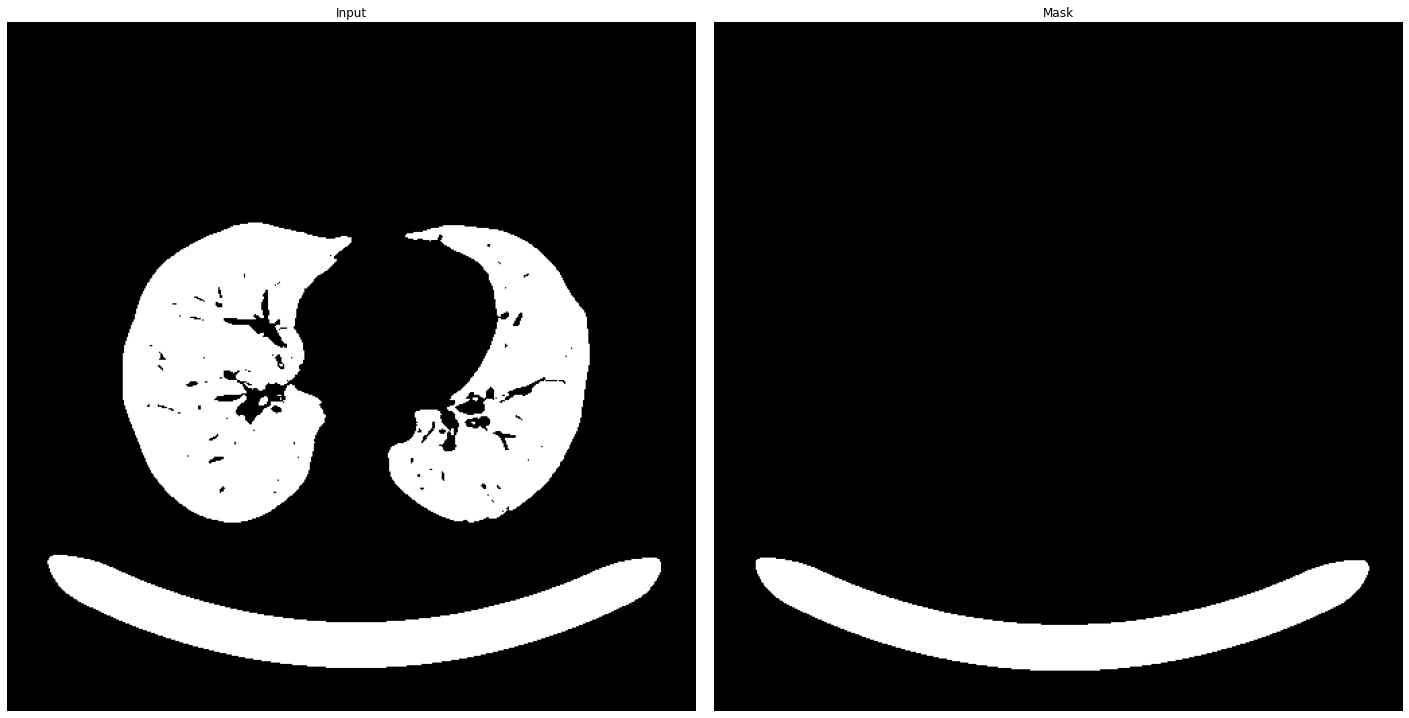

0

In [51]:
kernel = np.ones((3,3), np.uint8)

print('copying')
img = label_image.copy().astype(np.uint8)
img[np.where(img > 0)] = 1

img_line = np.zeros_like(img)
img_internal = np.zeros_like(img)

print('generating')
for i in range(0,img.shape[2]):
    mask = img[:,:,i].copy()
    cv2.floodFill(mask, None, (0, 0), 255)
    mask = cv2.bitwise_not(mask)
    mask[np.where(mask > 0)] = 1

    img_erosion = cv2.erode(mask, kernel, iterations=2)
    img_dilation = cv2.dilate(mask, kernel, iterations=2)
    img_line[:,:,i] = cv2.bitwise_xor(img_erosion,img_dilation)
    img_internal[:,:,i] = img[:,:,i] - mask   

print('cleaning')
img_internal[np.where(img_line != 0)] = 0
img_internalClean = dustImage(img_internal,minArea = 100)
img_internalClean[np.where(img_internalClean > 0)] = 1

# img_internal = cv2.bitwise_xor(img,mask)
i = sliceNum
# pltm([img_erosion,img_dilation],25,['Erosion','Dilation'],cmap='gray')
pltm([img_internalClean[:,:,i],img_line[:,:,i]],25,['Internal','Line'],cmap='gray')
pltm([img[:,:,i],mask],25,['Input','Mask'],cmap='gray')

os.system("printf '\a'") # or '\7'

In [49]:
writePointCloud(img_line,'test'+patNum+'x','test'+patNum+'xd',xyz=True,voxel_size=5)
writePointCloud(img_internal,'test'+patNum+'xp','test'+patNum+'xpd',xyz=True,voxel_size=5)
# writePointCloud(cv2.erode(img_internal, kernel, iterations=1),'test1068xp','test1068xpd',xyz=True,voxel_size=5)

os.system("printf '\a'") # or '\7'

Stacking coordinates
Adding Color
Converting to Point Cloud


AttributeError: module 'open3d' has no attribute 'PointCloud'

This version of writing out a DICOM uses pydicom. It doesn't work properly in that when the new DICOM is imported into an imaging program like Slicer, it imports as only one axial slice.

<class 'pydicom.dataset.FileDataset'>
<class 'pydicom.dataset.FileDataset'>
(0010, 0010) Patient's Name                      PN: 'R_075'
(512, 512, 113)
/Users/john/Programming/Work/AnnotatedScans/scansDICOM//Pat002_Innards
1
(0020, 0013) Instance Number                     IS: "1"


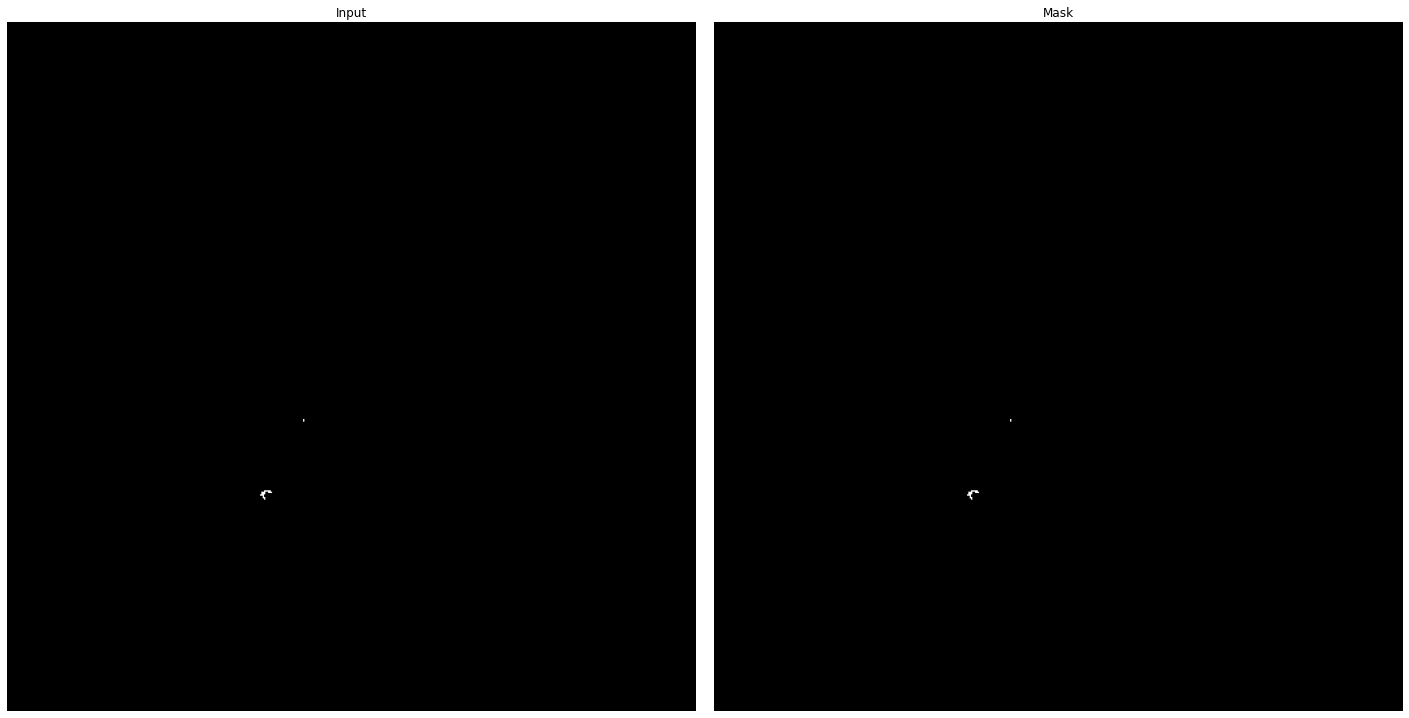

0

In [50]:
def writePartDicom(image,outfile):

    # RefDs.elements
    newDicom = copy.deepcopy(RefDs)

    print(type(newDicom))
    print(type(RefDs))
    print(newDicom[0x00100010])
    print(image.shape)
    print(outfile)
    for i in range(image.shape[2]):
        outFileName = outfile + '-'+str(i)+'.dcm'
#     print(outFileName)

        modification_time = time.strftime("%H%M%S")
        modification_date = time.strftime("%Y%m%d")


#         newDicom.SeriesDate = modification_date
#         newDicom.SeriesTime = modification_time
        newDicom.SeriesInstanceUID = newDicom.SOPInstanceUID
        newDicom.SeriesInstanceUID = "1"

        newDicom.pixel_data = np.uint16(copy.deepcopy(image[:,:,i]))
        newDicom.PixelData = newDicom.pixel_data
        newDicom.Rows = image.shape[0]
        newDicom.Columns = image.shape[1]
        newDicom.PixelSpacing[0] = spacing[0]
        newDicom.PixelSpacing[1] = spacing[1]
        newDicom.SliceThickness = 1.0
#         newDicom.InstanceNumber = i
#         newDicom.add_new(0x00200013,'IS',i)
        newDicom.ImagePositionPatient[2] = i
        newDicom.SliceLocation = i

        newDicom.save_as(outFileName)

        if i == 87 :
            print(newDicom.InstanceNumber)
            print(newDicom[0x00200013])
            pltm([newDicom.pixel_data,image[:,:,i]],25,['Input','Mask'],cmap='gray')

# print(newDicom.elements)
# print(512 * 512)

outputPath = '/Users/john/Programming/Work/AnnotatedScans/scansDICOM/'
filename = 'Pat'+patNum+'_Innards'

writePartDicom(img_internalClean,os.path.join(outputPath + '/' + filename))
os.system("printf '\a'") # or '\7'

In [224]:
# testFile = '/Users/john/Programming/Work/AnnotatedScans/Pat1068Padded//1068_7-1.dcm'
# testFile = '/Users/john/Programming/Work/AnnotatedScans/Pat1068_Innards/Pat1068_Innards-555.dcm'
testFile = '/Users/john/Programming/Work/AnnotatedScans/scansDICOM/Pat'+patNum+'_Innards-100.dcm'
# testFile = '/Users/john/Programming/Work/AnnotatedScans/scansDICOM//Pat002_Innards-100.dcm'
print(testFile)
pdicom.read_file(testFile)

/Users/john/Programming/Work/AnnotatedScans/scansDICOM/Pat002_Innards-100.dcm


(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.2.1125.1.74380680831475201864981041822974671
(0008, 0020) Study Date                          DA: '20191113'
(0008, 0021) Series Date                         DA: '20191113'
(0008, 0030) Study Time                          TM: '182956.066348'
(0008, 0031) Series Time                         TM: '182954'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CT'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 1030) Study Description                   LO: 'Pat002_Innards'
(0008, 103e) Series Description                  LO: 'Created-SimpleITK'
(0010, 0010) Patient's Name                      PN: 'Pat002'
(0010, 0020) Patient ID                          LO: "['Pat002_Innards', 'dcm']"
(0010, 0030) Patien

In [314]:
import SimpleITK as sitk

def writeSlices(series_tag_values, new_img, spacing, i, outputPath, filename):
    image_slice = new_img[:,:,i]

    # Tags shared by the series.
    list(map(lambda tag_value: image_slice.SetMetaData(tag_value[0], tag_value[1]), series_tag_values))

    # Slice specific tags.
#     image_slice.SetMetaData("0008|0012", time.strftime("%Y%m%d")) # Instance Creation Date
#     image_slice.SetMetaData("0008|0013", time.strftime("%H%M%S")) # Instance Creation Time

    # (0020, 0032) image position patient determines the 3D spacing between slices.
    image_slice.SetMetaData("0020|0032", '\\'.join(map(str,new_img.TransformIndexToPhysicalPoint((0,0,i))))) # Image Position (Patient)
    image_slice.SetMetaData("0020|0013", str(i)) # Instance Number

    # Don't know why the spacing metadata can't be set directly (0028|0030) but it defaults to 1.0 if done that way.
    image_slice.SetSpacing(spacing)
    # Write to the output directory and add the extension dcm, to force writing in DICOM format.
    writer = sitk.ImageFileWriter()
    # Use the study/series/frame of reference information given in the meta-data
    # dictionary and not the automatically generated information from the file IO
    writer.KeepOriginalImageUIDOn()
    
    writer.SetFileName(os.path.join(outputPath,os.path.basename(filename)+'-'+str(i)+'.dcm'))
    writer.Execute(image_slice)

def writeDICOM(image, outputPath, filename,patName,seriesUID,seriesDescription,spacing):
    modification_time = time.strftime("%H%M%S")
    modification_date = time.strftime("%Y%m%d")

    direction = [1, 0, 0, 0, 1, 0]
#     spacing = ['1.1','1.0']
    thickness = 1.0
    rows = image.shape[0]
    columns = image.shape[1]
    
    print(outputPath,filename)
    
    # Before the image can be saved, it needs the x and z dimensions swapped. ITK DICOM axis are z, y, x
#     itk_image = sitk.GetImageFromArray(image)
#     itk_image = sitk.GetImageFromArray(np.rot90(np.swapaxes(image,0,2),2))
    itk_image = sitk.GetImageFromArray(np.swapaxes(np.swapaxes(image,0,1),0,2))
    
    parts = filename.split('.')
    description = parts[0]

    series_tag_values = [
                        ("0008|0008","DERIVED\\SECONDARY"), # Image Type
                        ("0008|0021",modification_date),    # Series Date
                        ("0008|0031",modification_time),    # Series Time
                        ("0008|0060", "CT"),                # Type to CT 
                        ("0008|1030", description),         # Series Description
                        ("0008|103e", "Created-SimpleITK"), # Series Description
                        ("0010|0010", patName),             # Patient Name
                        ("0010|0020", str(parts)),       # Patient ID
                        ("0018|0050", str(thickness)), # Series Description
                        ("0018|1030", seriesDescription),   # Series Description
                        ("0020|000d", "1"),                 # Study Instance UID
                        ("0020|000e", seriesUID+modification_date+".1"+modification_time), # Series Instance UID
                        ("0020|0010", "123456"),            # Study #
                        ("0020|0011", "123456"),            # Series #
                        ("0020|0037", '\\'.join(map(str, (direction[0], direction[1], direction[2],# Image Orientation (Patient)
                                                        direction[3],direction[4],direction[5])))),
                        ("0028|0010", str(rows)),
                        ("0028|0011", str(columns))
                        ] 


    # Write slices to output directory
    err = list(map(lambda i: writeSlices(series_tag_values, itk_image,spacing, i,outputPath,description), range(itk_image.GetDepth())))

#     print(series_tag_values)

In [384]:
testFile = 'Pat'+patNum+'_Innards.dcm'
testOutPath = '/Users/john/Programming/Work/AnnotatedScans/scansDICOM/'
patientName = 'Pat'+patNum
seriesUID = "1.2.826.0.1.3680043.2.1125."
seriesDescrip = 'Vasculature Only'

writeDICOM(img_internalClean,outputPath,testFile,patientName,seriesUID,seriesDescrip,spacing)

print('wrote file: x',testFile,'x')
print('at: x',testOutPath,'x')


/Users/john/Programming/Work/AnnotatedScans/scansDICOM/ Pat002_Innards.dcm
wrote file: x Pat002_Innards.dcm x
at: x /Users/john/Programming/Work/AnnotatedScans/scansDICOM/ x


In [75]:
testFile = 'Pat'+patNum+'_Lung.dcm'
testOutPath = '/Users/john/Programming/Work/AnnotatedScans/scansDICOM/'
patientName = 'Pat'+patNum
seriesUID = "1.2.826.0.1.3680043.2.1125."
seriesDescrip = 'Lung Only'
writeDICOM(img_line,outputPath,testFile,patientName,seriesUID,seriesDescrip)

512 512 ['1.1', '1.0']
/Users/john/Programming/Work/AnnotatedScans/scansDICOM/ Pat002_Lung.dcm


In [76]:
ConstPixelDims[0] = 751
ConstPixelDims[1] = 751
ArrayDicomTest = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)


print(ConstPixelDims)

print(img_internal.shape)
# loop through all the DICOM files
for i in range(img_internal.shape[2]):
    # read the file
    inFileName = os.path.join(outputPath + '/' + filename) + '-'+str(i)+'.dcm'

    ds = pdicom.read_file(inFileName)
    
    # Store the raw image data
    ArrayDicomTest[:, :, pdicom.read_file(filenameDCM).InstanceNumber] = ds.pixel_array
    
    pltm([ArrayDicomTest,img_internal[:,:,i]],25,['Input','Mask'],cmap='gray')


[751 751 273]
(512, 512, 273)


NameError: name 'filenameDCM' is not defined

In [274]:
type(RefDs.PixelSpacing)
img_internal.shape
print(type(img_internal[0,0,0]))
print(751*751)

<class 'numpy.uint8'>
564001


In [ ]:
sliceNum = 250
# nImage = np.rot90(np.swapaxes(img_internal,0,2),1)
nImage = np.rot90(img_internal)
# nImage = np.swapaxes(img_internal,0,2)

# plti(nImage[:, :, sliceNum],8,title = "Slice Number {}".format(sliceNum),cmap='gray')
pltm([nImage[:, :, sliceNum],img_internal[:,:,sliceNum]],25,['Input','Mask'],cmap='gray')
pltm([nImage[sliceNum, :, :],img_internal[:,sliceNum,:]],25,['Input','Mask'],cmap='gray')



In [ ]:
m = np.array([[1,2],[3,4]], int)
print('m',m)


print('m90',np.rot90(m))


print('m180',np.rot90(m, 2))


# m = np.arange(12).reshape((3,2,2))

m = np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2])
m = m.reshape((3,2,2))

print('\nm',m)
print('\n(0,1)\n',np.rot90(m, 1, (0,1)))
print('\n(1,2)\n',np.rot90(m, 1, (1,2)))
print('\n(0,2)\n',np.rot90(m, 1, (0,2)))

In [ ]:
m = np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2])
m = m.reshape((3,2,2))

print('\nm',m)

print('\n(0,1)\n',np.swapaxes(m,0,1))
print('\n(1,2)\n',np.swapaxes(m,1,2))
print('\n(0,2)\n',np.swapaxes(m,0,2))

In [94]:
print(spacing[0:2])

[0.68164062 0.68164062]
